In [1]:
%matplotlib inline
import csv
from math import sqrt
import math
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# from preprocess_polluscope_data_utility import transform_polluscope_data
# transform_polluscope_data("pm2,5_2020.csv","Cleaned_PM_Data.csv",["timestamp","canarin_id","pm2.5"])

In [ ]:
# from pandas import read_csv
# from matplotlib import pyplot
# # load dataset
# dataset = read_csv('all_kits_withActivities.csv', header=0, index_col=0)
# values = dataset.values
# print(values)
# # specify columns to plot
# groups = [0]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

# Loading data 

In [3]:
# load dataset
dataset = read_csv('all_kits_.csv', header=0, index_col=0)
values = dataset.values
values.shape

(108796, 2)

# Encode, reframe and rescale:
## Categorical data are encoded to int

In [4]:
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])


# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)   var1(t)
1   0.015797        1.0  0.014797
2   0.014797        1.0  0.014397
3   0.014397        1.0  0.014397
4   0.014397        1.0  0.014997
5   0.014997        1.0  0.014797


In [5]:
# split into train and test sets
values = reframed.values
n_train_hours = 46000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
print(train_y)
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[0.01479704 0.01439712 0.01439712 ... 0.00019996 0.00019996 0.00019996]
(46000, 1, 2) (46000,) (62795, 1, 2) (62795,)


Epoch 1/50
639/639 - 5s - loss: 0.0023 - val_loss: 0.0134 - 5s/epoch - 7ms/step
Epoch 2/50
639/639 - 2s - loss: 0.0020 - val_loss: 0.0032 - 2s/epoch - 4ms/step
Epoch 3/50
639/639 - 2s - loss: 0.0016 - val_loss: 0.0080 - 2s/epoch - 4ms/step
Epoch 4/50
639/639 - 2s - loss: 0.0011 - val_loss: 0.0066 - 2s/epoch - 4ms/step
Epoch 5/50
639/639 - 2s - loss: 0.0012 - val_loss: 0.0070 - 2s/epoch - 4ms/step
Epoch 6/50
639/639 - 3s - loss: 9.5110e-04 - val_loss: 0.0021 - 3s/epoch - 4ms/step
Epoch 7/50
639/639 - 2s - loss: 6.7401e-04 - val_loss: 0.0028 - 2s/epoch - 4ms/step
Epoch 8/50
639/639 - 2s - loss: 6.5513e-04 - val_loss: 0.0021 - 2s/epoch - 4ms/step
Epoch 9/50
639/639 - 2s - loss: 6.5246e-04 - val_loss: 0.0016 - 2s/epoch - 4ms/step
Epoch 10/50
639/639 - 2s - loss: 5.7362e-04 - val_loss: 0.0023 - 2s/epoch - 4ms/step
Epoch 11/50
639/639 - 2s - loss: 5.6942e-04 - val_loss: 0.0018 - 2s/epoch - 4ms/step
Epoch 12/50
639/639 - 2s - loss: 7.0808e-04 - val_loss: 0.0029 - 2s/epoch - 4ms/step
Epoch 13/

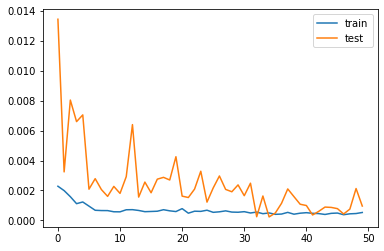

In [6]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [8]:
print("Predicted Series is: \n",inv_yhat)
print("Actual Series is: \n",inv_y)
difference = abs(inv_yhat - inv_y)
print('Difference Series is: \n',difference)

Predicted Series is: 
 [5.5120373 5.5120373 4.5122805 ... 2.860972  3.8163528 3.8163528]
Actual Series is: 
 [1. 0. 0. ... 6. 6. 4.]
Difference Series is: 
 [4.5120373  5.5120373  4.5122805  ... 3.139028   2.1836472  0.18364716]


In [17]:
file = open("difference_activities.csv", 'w')
writer = None
with file:
    fnames = ['yhat','y','diff']
    writer = csv.DictWriter(file, fieldnames=fnames)
    writer.writeheader()
    i=0
    for dif in difference:
        writer.writerow({'yhat':inv_yhat[i],
                        'y':inv_y[i],
                        'diff':dif
                        })
        i+=1
count=0
index = 0
for dif in difference:
    dat = inv_yhat[index-3:index+3]
    if dat.size==0:
        print('dis')
        dat.insert(inv_yhat[index])
    median = getThreshold(inv_y[index-3:index+3],10)
    if dif>100:
        count+=1
        print(dif)
        print(inv_y[index])
        print("on index: ",index)
    index+=1
print("max is:\n ",max(difference))
print("count of >= 10 is: \n",count)

dis


AttributeError: 'numpy.ndarray' object has no attribute 'insert'

In [11]:
import statistics as stat

In [12]:
def getThreshold(data,percentage):
    print("data is ",data)
    avg = stat.mean(data)
    mean= avg + avg*percentage/100
    print("mean is:")
    print(mean)

In [ ]:
print("Predicted value:",inv_yhat)
print("\n While real value is ",inv_y)
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
 
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg
 
# # load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# # ensure all data is float
# values = values.astype('float32')
# # normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# # specify the number of lag hours
# n_hours = 3
# n_features = 8
# # frame as supervised learning
# reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed.shape)
 
# # split into train and test sets
# values = reframed.values
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# n_obs = n_hours * n_features
# train_X, train_y = train[:, :n_obs], train[:, -n_features]
# test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# # fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
 
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)

In [ ]:
import numpy as np
lt = [["A","B","C","D",],
       ["E","F","G","H",],
       ["I","J","K","L",],
       ["M","N","O","P",]]
lst = np.array(lt)
PLAIN_X, PLAIN_y = lst[:, :-1], lst[:, -1]
print(PLAIN_X)
print(PLAIN_y)

In [ ]:
# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
 
# # convert series to supervised learning
# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg
 
# # load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# # ensure all data is float
# values = values.astype('float32')
# # normalize features
# # scaler = MinMaxScaler(feature_range=(0, 1))
# # scaled = scaler.fit_transform(values)
# # frame as supervised learning
# reframed = series_to_supervised(values, 1, 1)
# print('this is after calliing supervised function: \n',reframed)
# # drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
# print(reframed.head())
 
# # split into train and test sets
# values = reframed.values
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
# # split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mae', optimizer='adam')
# # fit network
# history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# # plot history
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()
 
# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# # calculate RMSE
# rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)